# Projet SOIA 6.1 - PINN
## Oscar Agnus, SOIA A3


Now, let's go in 2D. The heat equation is given by:
$$
f(x,t) = \nu (\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}) = \Delta u
$$

where $u$ is the temperature,
$x$ is the space coordinate,
$t$ is the time coordinate,
and $\nu$ is the thermal diffusivity.


In [1]:
# Imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

import pinnde.pde_Solvers as pde_Solvers
import pinnde.pde_Initials as pde_Initials
import pinnde.pde_Boundaries_2var as pde_Boundaries

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Weights and Biases - this is for logging the results
import wandb

## Setting up the problem

Here, we define the problem in physical terms, and format it so that it can be used by the neural network.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleNetwork(nn.Module):
    """Custom neural network with 8 hidden layers."""
    def __init__(self, input_size):
        super(SimpleNetwork, self).__init__()
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, 20) for _ in range(8)])
        self.output_layer = nn.Linear(20, input_size)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = torch.tanh(layer(x))
        x = self.output_layer(x)
        return x

In [3]:
# Space domain
x_min = -1 
x_max = 1
N_x = 1000 # Number of points in the space domain
X_bc = np.array([x_min, x_max]) # Boundary conditions points

y_min = -1 
y_max = 1
N_y = 1000 # Number of points in the space domain
Y_bc = np.array([y_min, y_max]) # Boundary

# Define useful parameters
nu = 0.01 # Thermal diffusivity

def f(x):
    """Source of the heat equation."""
    return torch.zeros_like(x)

# Initial conditions
def u_ic(x):
    """Initial conditions for the heat equation."""
    return torch.zeros_like(x)

def u_bc(x):
    """Boundary conditions for the heat equation."""
    return torch.zeros_like(x)

# Exact solution, or the finite difference solution
def u_exact(x):
    """Exact solution of the heat equation.
    The solution is given for each instant, and the space domain can be multidimensional.
    :param x: space domain, discretized
    :param t: time domain, discretized"""

    u = torch.zeros_like(x)
    return u

# Generate boundary points 
def generate_boundary_points(N):
    """Generate N points, randomly distributed on the boundary.""" 
    x = torch.zeros(1, N, 2)
    for i in range(N):
        if i < N//4:
            x[0][0][i] = x_min
            x[0][1][i] = np.random.uniform(y_min, y_max)
        elif N// 4 <= i < N//2:
            x[0][0][i] = x_max
            x[0][1][i] = np.random.uniform(y_min, y_max)
        elif N//2 <= i < 3*N//4:
            x[0][0][i] = np.random.uniform(x_min, x_max)
            x[0][1][i] = y_min
            
    return x

inputs = generate_boundary_points(100)
print("inputs.shape: ", inputs.shape)

IndexError: index 2 is out of bounds for dimension 0 with size 2

In [369]:
# Define the model
# my_model = models.resnet18()
# my_model = ResNet18()

# my_model = SimpleNetwork(N_x)

my_model = torch.nn.Sequential(
    torch.nn.Linear(N_x, 20),
    torch.nn.Tanh(),
    torch.nn.Linear(20, 20),
    torch.nn.Tanh(),
    torch.nn.Linear(20, 20),
    torch.nn.Tanh(),
    torch.nn.Linear(20, 20),
    torch.nn.Tanh(),
    torch.nn.Linear(20, 20),
    torch.nn.Tanh(),    
    torch.nn.Linear(20, 20),
    torch.nn.Tanh(),
    torch.nn.Linear(20, 20),
    torch.nn.Tanh(),
    torch.nn.Linear(20, 20),
    torch.nn.Tanh(),
    torch.nn.Linear(20, 20),
    torch.nn.Tanh(),
    torch.nn.Linear(20, N_x),
)


## Loss functions
Here are defined the loss functions. There are 3 different loss functions:
- $L_{data}$ : loss function for the data points
- $L_{bc}$ &nbsp; &nbsp;: loss function for the boundary conditions
- $L_{pde}$ : loss function for the PDE

All of them use the Mean Squared Error (MSE) with the given data points.
Each one of them will be used with their relative weight, which represent their importance, in the composite loss function.

In [6]:
# Gradient function
def grad(outputs, inputs):
    """Compute the gradient of 'outputs' with respect to 'inputs'."""
    return torch.autograd.grad(outputs = outputs, inputs = inputs, grad_outputs = torch.ones_like(outputs), create_graph = True)[0]

# Loss functions
def loss_data(u_pred, u_gt):
    """Loss function for the data points."""
    return torch.nn.MSELoss()(u_pred, u_gt)

def loss_bc(u_pred, u_bc):
    """Loss function for the boundary conditions."""
    return torch.nn.MSELoss()(u_pred, u_bc)

def loss_pde(u_pred, x_pde):
    """Loss function for the PDE.
    Needs to be changed in case of a different PDE."""
    u_x  = grad(u_pred, x_pde) # First order derivative
    u_xx = grad(u_x, x_pde)    # Second order derivative
    return torch.nn.MSELoss()(f(x_pde), nu*u_xx)

def loss_composite(u_gt, u_pred,u_bc, u_bc_pred, x_pde):
    """Composite loss function, combining the three loss functions."""
    # Weights for the composite loss function
    w_data = 1.0
    w_bc   = 1.0
    w_pde  = 1.0
    return w_data*loss_data(u_pred, u_gt) + w_bc*loss_bc(u_bc_pred, u_bc) + w_pde*loss_pde(u_pred, x_pde)

inputs.shape:  torch.Size([1, 1, 100])


Here we define the training and testing functions. We want to make a checkpoint of the model when the testing loss is minimal.

In [371]:
# Training function 
def train(model, optimizer, number_epoch):
    """Training function for the model."""
    model.train() # Set the model to training mode
    running_loss = 0.0
    inputs = torch.tensor(np.random.rand(1, N_y, N_x), dtype=torch.float32, requires_grad=True) # Collocation points, randomly distributed in the space domain

    # Training loop
    for n in range(number_epoch):
        inputs = inputs.to(device) # Send the inputs to the device (GPU or CPU)
        optimizer.zero_grad() # zero the parameter gradients
        outputs = model(inputs) # forward pass

        # Boundary conditions
        # inputs_bc, _ = open_boundary(1000, np.repeat(X_bc[0], 500), np.repeat(X_bc[1], 500)) # Boundary conditions points and values
        inputs_bc = generate_boundary_points(N) # Boundary conditions points, randomly distributed in the space domain
        inputs_bc = inputs_bc.to(device)
        outputs_bc = model(inputs_bc) # Forward pass for the boundary
        
        loss = loss_composite(u_exact(inputs), outputs, inputs_bc, outputs_bc, inputs)
        loss.backward()
        optimizer.step()

        # Compute running statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        
    train_loss = running_loss / n_epoch

    return train_loss

### Training the model

Check in the PC configuration if the GPU is available. Cuda needs to be installed to use the GPU with PyTorch.
This will speed up the training process.

In [372]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Is cuda available: ', torch.cuda.is_available())
my_model.to(device)
print(f'Using device: {device}')

Is cuda available:  True
Using device: cuda


Here, we load the data and define the data loaders.

There isn't any testing data, because we will not use the accuracy metrics to assess the model.
The training data `u_data` will be either the exact solution, or some measured data. For now, we will not use any data, meaning `w_data = 0.0`.

In [373]:
# Training parameters
lr = 0.01
optimiser = optim.Adam(my_model.parameters(), lr=lr)

n_epoch = 500

# Training
t0 = time.time()
training_loss = train(my_model, optimiser, n_epoch)
t1 = time.time()

Here we initialise the wandb run, which will log the results of the training process.

In [374]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Projet SOIA 6.1 - PINN",

    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "resnet18",
    "dataset": "heat_equation_custom_solution",
    }
)

training_loss,▁▁
training_time,▁▁
training_loss,0.01332
training_time,6.56735


In [375]:
# Display the results

print(f"Training loss: {training_loss:.2f}")
print(f"Training time: {t1-t0:.2f} s")
# Log training results
wandb.log({"training_loss": training_loss, "training_time": t1-t0})

# Save the model
torch.save(my_model.state_dict(), "PINN_model.pth")

Training loss: 0.01
Training time: 6.11 s


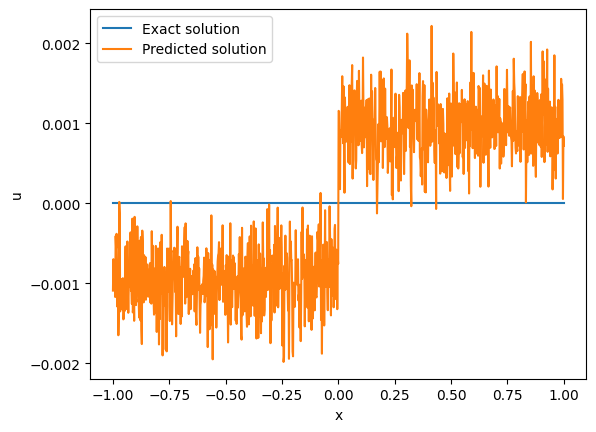

In [376]:
# Plot solution
X_test = torch.tensor([[np.linspace(x_min, x_max, 1000)]], dtype=torch.float32, requires_grad=True)
X_test = X_test.to(device)

u_pred = my_model(X_test)
u_test = u_exact(X_test)

# Move tensors to CPU before converting to NumPy arrays
X_test = X_test.cpu().detach().numpy()
u_pred = u_pred.cpu().detach().numpy()
u_test = u_test.cpu().detach().numpy()

plt.plot(X_test[0][0], u_test[0][0], label="Exact solution")
plt.plot(X_test[0][0], u_pred[0][0], label="Predicted solution")
plt.xlabel("x")
plt.ylabel("u")
plt.legend()
plt.show()